In [1]:
import pandas as pd
import numpy as np
import regex as re
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import nltk
from zipfile import ZipFile
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import string
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
df.duplicated().sum()

418

In [5]:
df.drop_duplicates(inplace=True, ignore_index=True)

In [6]:
df['review'] = df['review'].str.replace(r'<.*?>', '', regex=True)

In [7]:
df['review'] = df['review'].str.replace(r'[^\w\s]', '', regex=True)

In [8]:
df['review'] = df['review'].str.lower()

In [9]:
nltk.download('wordnet', download_dir='/root/nltk_data')
os.makedirs('/root/nltk_data/corpora', exist_ok=True)
nltk.data.path.append('/root/nltk_data')
with ZipFile('/root/nltk_data/corpora/wordnet.zip', 'r') as zip_ref:
    zip_ref.extractall('/root/nltk_data/corpora')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
lemmatizer = WordNetLemmatizer()

In [11]:
lemmatizer.lemmatize('ate', pos='v')

'eat'

In [12]:
df['review'] = df['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos='v') for word in x.split()]))

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [16]:
df["review"] = df["review"].apply(remove_stopwords)

In [17]:
df

,review,sentiment
0,one reviewers mention watch 1 oz episode youll...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically theres family little boy jake think ...,negative
4,petter matteis love time money visually stun f...,positive
...,...,...
49577,think movie right good job wasnt creative orig...,positive
49578,bad plot bad dialogue bad act idiotic direct a...,negative
49579,catholic teach parochial elementary school nun...,negative
49580,im go disagree previous comment side maltin on...,negative


In [18]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [19]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [20]:
df['sentiment'] = df['sentiment'].astype(int)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49582 entries, 0 to 49581
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49582 non-null  object
 1   sentiment  49582 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 774.8+ KB


In [22]:
X = df['review']
y = df['sentiment']

In [23]:
max_sequence_len = 0
for sentence in X:
    max_sequence_len = max(len(sentence), max_sequence_len)
print(max_sequence_len)

8753


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


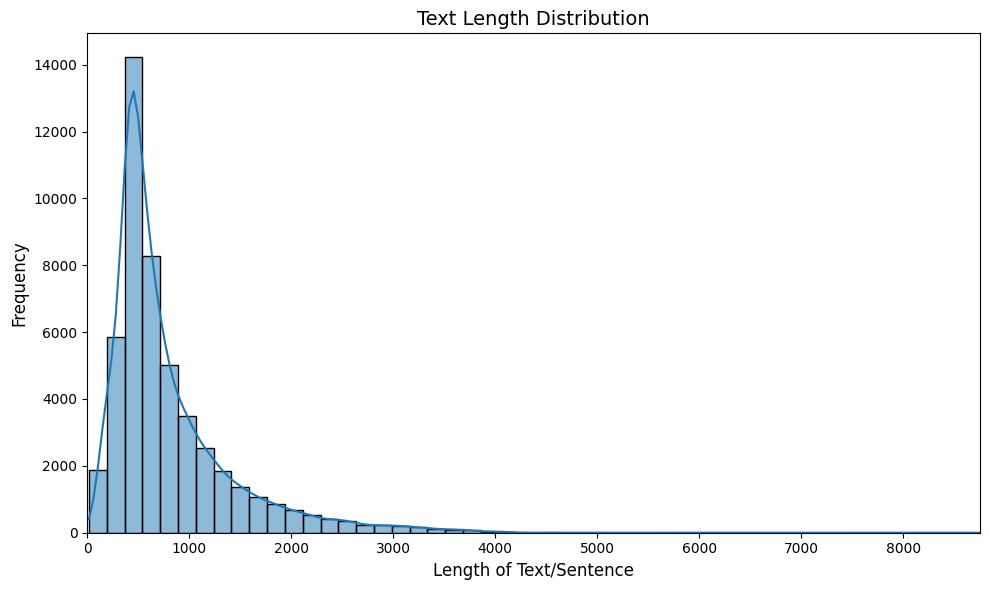

In [24]:
length_text = [len(text) for text in X]
plt.figure(figsize=(10, 6))  
sns.histplot(data=length_text, bins=50, kde=True)  
plt.xlabel('Length of Text/Sentence', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Text Length Distribution', fontsize=14)
plt.xlim(0, max(length_text) + 1)  
plt.tight_layout()  
plt.show()

In [25]:
length_df = pd.DataFrame(length_text)

In [26]:
length_df.describe()

,0
count,49582.000000
mean,804.070388
std,620.595698
min,17.000000
25%,420.000000
50%,591.000000
75%,978.000000
max,8753.000000


In [27]:
length_df.value_counts()

0   
424     118
441     113
419     113
405     112
433     111
       ... 
3882      1
3804      1
3806      1
3807      1
3808      1
Name: count, Length: 3303, dtype: int64

In [28]:
max_sequence_len = 200

In [29]:
tokenizer = Tokenizer(num_words=10000)  
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)

In [30]:
len(X_sequences)

49582

In [31]:
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_len, dtype='float32', padding='post')

In [32]:
X_padded.shape

(49582, 200)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [34]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64).prefetch(tf.data.experimental.AUTOTUNE)

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10001, output_dim=64, input_length=max_sequence_len),  
    tf.keras.layers.GRU(64),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [36]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights='True')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=3, factor=0.5, verbose=1, min_lr=0.00001)

In [37]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset,
                    shuffle=True, callbacks=[early_stopping, reduce_lr])

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5079 - loss: 0.6925 - val_accuracy: 0.5240 - val_loss: 0.6845 - learning_rate: 0.0010
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5287 - loss: 0.6848 - val_accuracy: 0.6628 - val_loss: 0.6532 - learning_rate: 0.0010
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7761 - loss: 0.4644 - val_accuracy: 0.8888 - val_loss: 0.2733 - learning_rate: 0.0010
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9153 - loss: 0.2192 - val_accuracy: 0.8869 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9470 - loss: 0.1535 - val_accuracy: 0.8785 - val_loss: 0.3196 - learning_rate: 0.0010
Epoch 6/10
615/620 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9668 - loss: 0.1061
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
620/620 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9669 - loss: 0.1060

In [40]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8857 - loss: 0.2778
Test Accuracy: 0.8888


In [41]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)    
    text = text.translate(str.maketrans('', '', string.punctuation))    
    text = text.lower()    
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    cleaned_text = ' '.join(cleaned_words)
    return cleaned_text

In [42]:
def predict_sentence(sentence, model, tokenizer, max_sequence_len):
    cleaned_sentence = clean_text(sentence)    
    sequence = tokenizer.texts_to_sequences([cleaned_sentence])    
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_len, padding='post')        
    prediction = model.predict(padded_sequence)    
    prediction = prediction[0][0]
    if prediction >= 0.5:
        prediction = 'Positive'
    else:
        prediction = 'Negative'
    return prediction

In [43]:
sentence = "This product is terrible! It broke after just one use, and the customer service was unhelpful. I regret buying it and would not recommend it to anyone."
prediction = predict_sentence(sentence, model, tokenizer, max_sequence_len)
print(f"Prediction: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Prediction: Negative
